## Frangi 2D

## Implementation methods ARCADE 2D

### Loop for testing parameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# ——— Main (unchanged) ———
image_path = '../../nnNet_training/Raw_data/Dataset_train_val/imagesTr/sten_0000_0000.png'
I = imread(image_path, as_gray=True).astype(np.float64)
if I.max() > 1: I /= 255.0

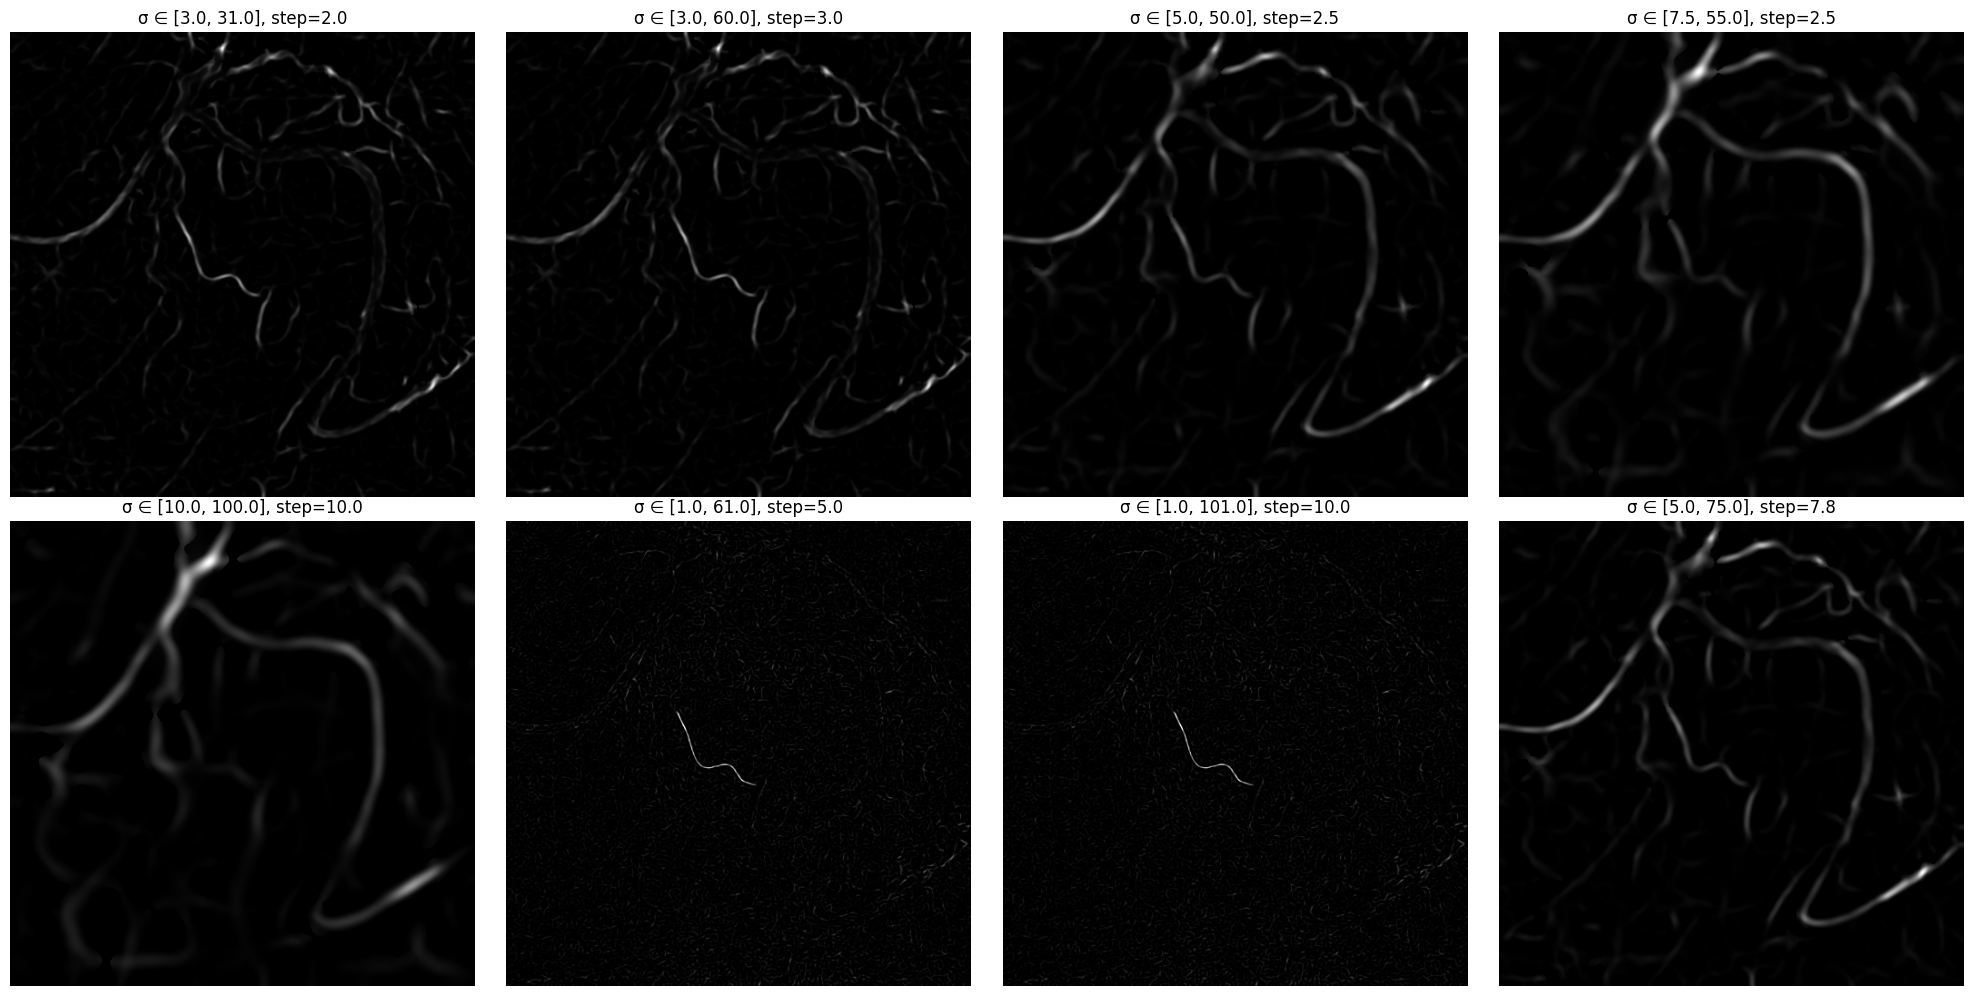

In [ ]:
from skimage.filters import frangi

sigma_sets = [
    np.arange(3, 32, 2),
    np.arange(3, 63, 3),
    np.arange(5, 52.5, 2.5),
    np.arange(7.5, 57.5, 2.5),
    np.arange(10, 110, 10),
    np.arange(1, 65, 5),
    np.arange(1, 110, 10),
    np.linspace(5, 75, 10)
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for ax, sigmas in zip(axes, sigma_sets):
    v = frangi(
        I.astype(float),
        sigmas=sigmas,
        alpha=1.0,
        beta=1.0,
        gamma=0.1,
        black_ridges=True,
        mode='reflect'
    )
    ax.imshow(v, cmap='gray')
    ax.set_title(f"σ ∈ [{sigmas[0]:.1f}, {sigmas[-1]:.1f}], step={sigmas[1]-sigmas[0]:.1f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

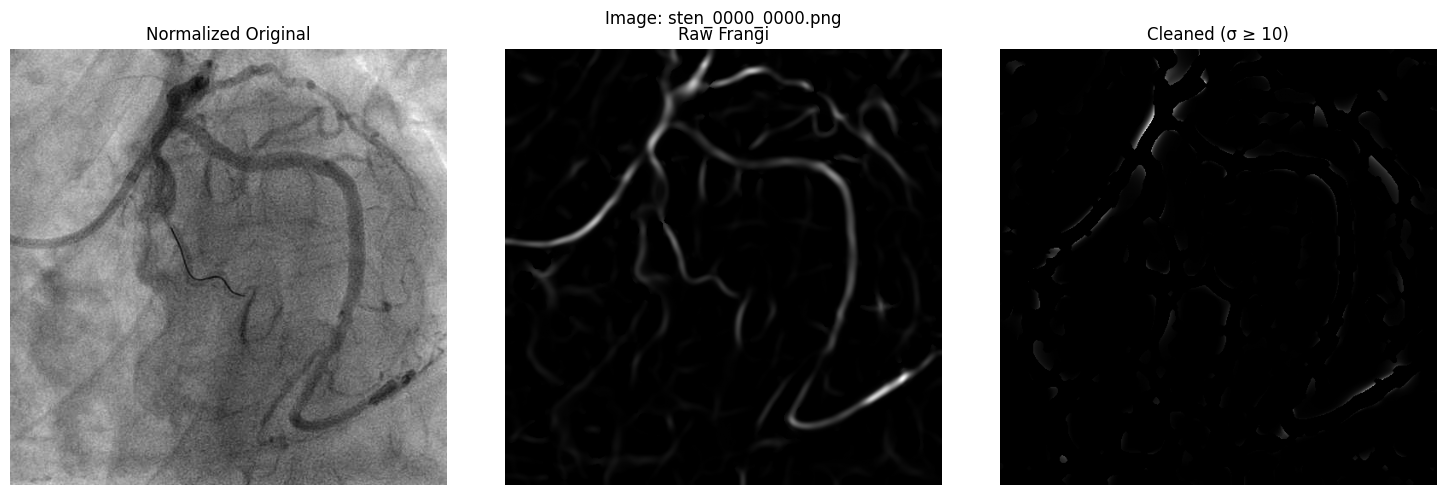

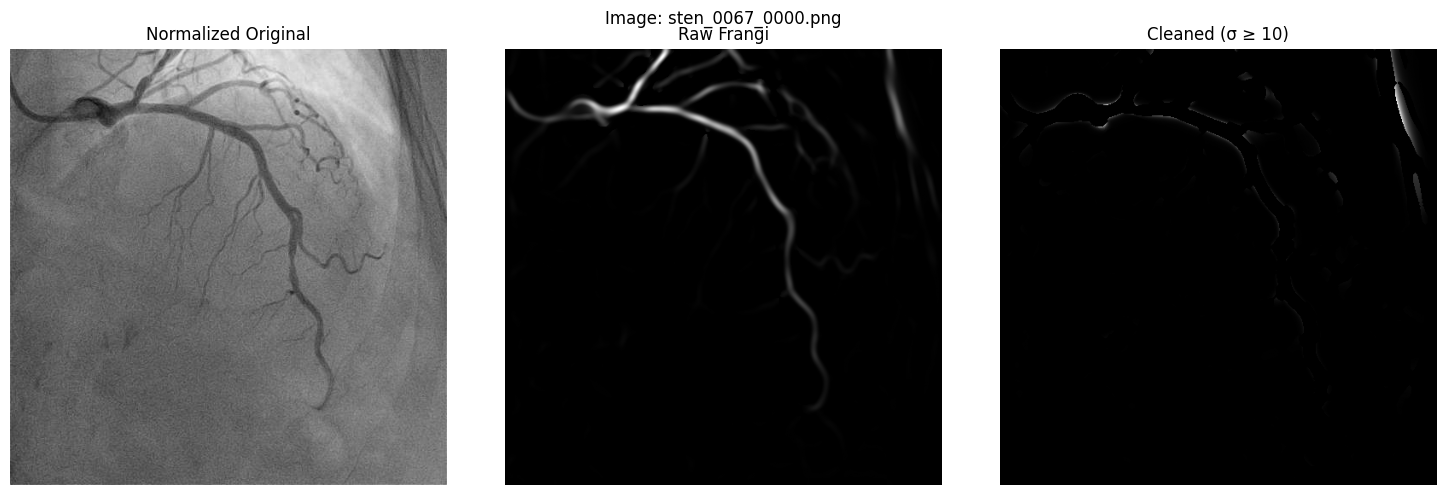

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import frangi
from skimage.morphology import opening, disk

def adaptive_frangi_cleanup(I, sigmas=np.arange(6, 85, 1), sigma_min=10, opening_radius=2):
    """
    Compute Frangi vesselness, then suppress thin artifacts by scale thresholding and morphological opening.
    
    Parameters:
    - I: 2D normalized image (float64, range [0,1])
    - sigmas: 1D array of scales for Frangi
    - sigma_min: minimum "winning" scale to keep
    - opening_radius: radius for morphological opening
    """
    # 1) Build vesselness stack
    stack = np.stack([frangi(I, sigmas=(s, s), alpha=1, beta=1, gamma=10,
                             black_ridges=True, mode='reflect')
                      for s in sigmas], axis=0)
    
    # 2) Best response & corresponding scale per pixel
    best_resp = np.max(stack, axis=0)
    best_idx  = np.argmax(stack, axis=0)
    best_sigma = sigmas[best_idx]
    
    # 3) Mask out thin-scale responses
    mask = best_sigma >= sigma_min
    
    # 4) Morphological opening to remove tiny ridges
    mask_open = opening(mask, disk(opening_radius))
    
    # 5) Apply mask to vesselness
    V_clean = best_resp * mask_open
    
    return best_resp, V_clean

# === Test on two sample images ===
input_dir = "arcade"  # <-- REPLACE with your folder
# pick first two image files in the directory
files = sorted([f for f in os.listdir(input_dir)
                if f.lower().endswith(('.png', '.jpg', '.tif'))])[:2]

for fname in files:
    path = os.path.join(input_dir, fname)
    I = imread(path, as_gray=True).astype(np.float64)
    I_norm = (I - I.min()) / (I.max() - I.min())
    
    # Run adaptive cleanup
    V_raw, V_clean = adaptive_frangi_cleanup(I_norm,
                                             sigmas=np.arange(6, 85, 1),
                                             sigma_min=10,
                                             opening_radius=2)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(I_norm, cmap='gray')
    axes[0].set_title("Normalized Original")
    axes[1].imshow(V_raw, cmap='gray')
    axes[1].set_title("Raw Frangi")
    axes[2].imshow(V_clean, cmap='gray')
    axes[2].set_title("Cleaned (σ ≥ 10)")
    for ax in axes:
        ax.axis('off')
    plt.suptitle(f"Image: {fname}")
    plt.tight_layout()
    plt.show()
